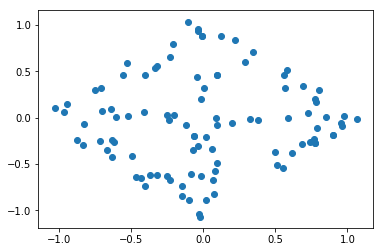

In [7]:
%matplotlib inline
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import cluster
from IPython.display import Image
from scipy.spatial.distance import squareform, pdist

import warnings
warnings.filterwarnings('ignore')

np.random.seed(300)
cloud = np.genfromtxt('data/wheel.txt', delimiter=' ') #load a noisy sample from a wheel graph
random_indices = np.random.choice( cloud.shape[0], 100 ) # sample 100 indicies from the cloud
subcloud = cloud[random_indices, ] # create a subcloud
plt.scatter(subcloud[:, 0], subcloud[:, 1]) # plot the subcloud
plt.show()

## Part 2. Clustering of real data

### 2.1. Motivations of clustering

When working with real data, one can start from <i>clustering</i> of the data, which means splitting a given dataset into subgroups called <i>clusters</i>. This first step might also help detect <i>outliers</i>, i.e. data points that are very different (far away) from the rest of the data. 

There is no unique formal definition of a cluster. Informally, data points within the same cluster are expected to be more similar to each other than to data points from other clusters. Usually clusters don't overlap, though more general cases are possible and will be considered later.

There are thousands of different clustering algorithms, so there is no canonical statement of the clustering problem. A clustering algorithm may minimize a cost function (say, a measure of dissimilarity between points within every cluster) under certain constraints, for example, a required number of clusters can be given.

### 2.2. Classical k-means clustering

A classical example is $k$-means clustering. This is an iterative algorithm that starts from (usually) random $k$ centers (among all data points) and iteratively optimizes their positions by assigning closest points to their centers and updating centers of resulting clusters.

So the input consists of a point cloud and a number $k$ of expected clusters. In the code below the points are taken from the subcloud shown in the picture above.

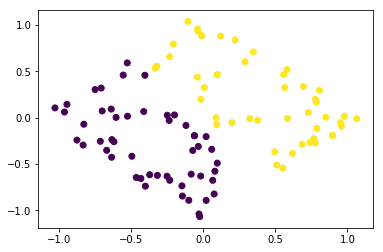

In [16]:
# run the k-means algorithm for the subcloud above
kmeans = cluster.KMeans(n_clusters=2, n_init=200,
                            random_state=456, max_iter=300).fit(subcloud)
# plot the subcloud with where points are 
# colored according to their cluster
plt.scatter(subcloud[:,0], subcloud[:,1], c=kmeans.labels_)
plt.show()

Feel free to change the value of $k$ in the code above to gain some intuition about clustering. Since the original cloud is rather complicated (not splitting into obvious groups), there is no good value of $k$ (apart from $k=1$) for clustering of this subcloud.

### 2.3. MST : a Minimum Spanning Tree 

A graph is connected if any two vertices can be joined by a sequence (or a <i>path</i>) of edges, where any two successive edges share a common vertex. 

A <i>cycle</i> in a graph is a sequence of edges starting and finishing at the same vertex. A <i>tree</i> is a connected graph without cycles.

<b>Exercise</b>: find cycles and trees in the following collections of "graphical digits".

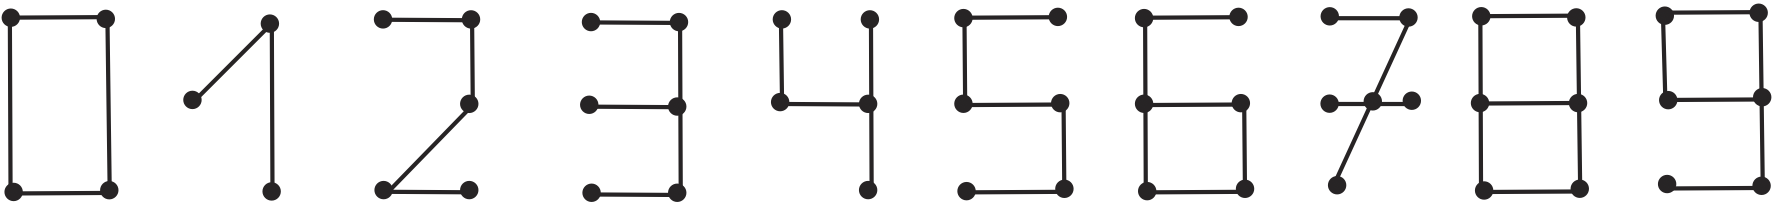

In [9]:
Image(filename='data/img/digits.png')

A <i>spanning tree</i> $T$ of a connected graph $G$ is a subgraph that contains all vertices of $G$ and no cycles. 

A graph is <i>weighted</i> if every edge has a positive length (or a <i>weight</i>). 

When vertices of a graph are a cloud of points in a Euclidean space, the weight of every edge $e$ in our tutorial will be the Euclidean distance ($L_2$-metric) between the vertices of $e$.

A <i>Minimum Spanning Tree</i> MST$(G)$ of a connected graph $G$ is a spanning tree $T$ of $G$ whose total length of edges is minimal. 

For a point cloud $C$ in a Euclidean space, MST$(C)$ is a Minimum Spanning Tree of the complete graph on $C$ containing a single straight-line edge for every pair of vertices from $C$.  

In a general position (when all distances between pairs of points in $C$ are different), MST$(C)$ is unique. However, if $C$ contains pairs of points at the same distance from each other, there is more than one spanning tree with the same total length of edges.

### 2.4. A single-edge clustering

For a point cloud $C$ and a distance threshold $\alpha\geq 0$, a <i>single-edge</i> clustering outputs the clusters such that 

1. all points of $C$ within a distance at most $\alpha$ are in the same cluster
2. if a shortest path (within MST$(C)$ or in a complete graph on $C$) between two points of $C$ contains an edge longer than $\alpha$, then these points belong to different clusters.

Condition 2 above explains the name <i>single-edge</i>, because any long enough edge may become a gap between resulting clusters.

The single-edge clustering can run for any distance threshold $\alpha$ from $0$ (when all clusters are isolated vertices) to the length of a longest edge in a Minimum Spanning Tree $MST(C)$, when all points of $C$ form a single cluster.

When the threshold $\alpha$ increases from 0 to its maximum value above, the clusters gradually merge into larger clusters until the whole cloud $C$ becomes one cluster. 

Hence the single-edge clustering can produce a hierarchy of <i>consistent</i> clusters across all thresholds such that all clusters at a smaller threshold are included (and never subdivided) into clusters at any larger threshold. 

The following code draws $MST(C)$ for a subcloud randomly selected above.

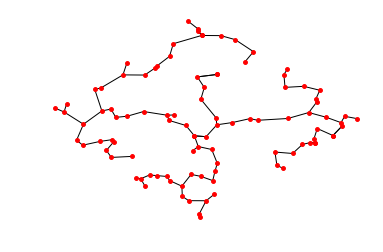

In [10]:
# create a dictionary with each points coordinates
pos = {i:(subcloud[i][0], subcloud[i][1]) for i in range(len(subcloud))}
# create a pairwise distance matrix for the subcloud
X = squareform(pdist(subcloud))
# create a complete graph from the distance matrix, with edge
# lengths equal to the distance between points
G = nx.from_numpy_matrix(X)
# calculate its minimum spanning tree
T = nx.minimum_spanning_tree(G)
#plot the MST
ax = plt.subplot(111)
nx.draw(T, pos, node_size=15, ax=ax)
plt.show()

### 2.5.  Universal optimality of MST

A Minimum Spanning Tree $MST(C)$ of a point cloud $C$ can be considered as a universal skeleton describing the connectivity (connected components) of $C$ across all thresholds. 

More formally, for any threshold $\alpha$, we many define a <i>reduced</i> $MST(C;\alpha)$ that is a subgraph of $MST(C)$ containing only edges of lengths at most $\alpha$. This subgraph still has no cycles, but may be disconnected, hence such a graph is often called a <i>forest</i>.

When the threshold $\alpha$ increases from $0$ to the maximum edge-length of $MST(C)$, the reduced $MST(C;\alpha)$ grows from the set of isolated vertices $C$ to the full $MST(C)$.

The following lemma is probably a folklore result, which will be later extended to higher dimensions.

<b>Lemma</b> (universal optimality of MST). 
For any threshold $\alpha$, a reduced $MST(C;\alpha)$ has the minimum total length among all graphs $G$ that have the same connected components as single-edge clusters of $C$ at the threshold $\alpha$.

The above result means that MST is a universal skeleton optimally describing the connectivity of a point cloud $C$ across all thresholds, i.e. $MST(C)$ contains reduced forests that remain optimal (have a minimum total length) for any threshold $\alpha$.

The following code draws a reduced $MST(C;\alpha)$ for the same subcloud $C$ generated above.

In [11]:
def reduced_MST(G, alpha):
    
    # create graph with no edges
    # with the same nodes as G
    graph = nx.Graph()
    graph.add_nodes_from(G)
    
    for edge in nx.minimum_spanning_edges(G):
        if edge[2]['weight'] >= alpha:
            break
        # if the edge is not greater than alpha
        # add it to the graph
        graph.add_edge(edge[0], edge[1])
        
    return graph

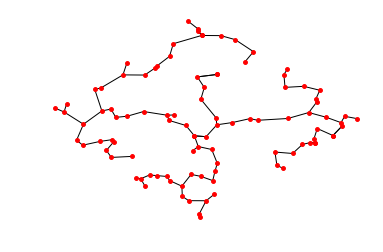

In [23]:
# get reduced tree
threshold = 0.40
tree = reduced_MST( G, threshold )

# plot the spanning tree
ax = plt.subplot(111)
nx.draw( tree, pos, node_size=15, ax=ax )
plt.show()

Feel free to vary the threshold parameter in the procedure reduced_MST( G, threshold ) above. 